# Example workflow: IOOS gliders in the Gulf Stream

In this example workflow we go through the steps of finding Gulf Stream gliders on the IOOS glider ERDDAP and plotting their tracks on a map. This notebooks is inteded as a template for using an ERDDAP to answer a scientific question.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import numpy as np
import cartopy
from erddapy import ERDDAP
import pandas as pd
from tqdm.notebook import tqdm
import cartopy
import cartopy.crs as ccrs

### 1. Setup the ERDDAP connection
In this case, we use the IOOS gliders ERDDAP https://gliders.ioos.us/erddap/index.html

In [2]:
e = ERDDAP(
    server="https://gliders.ioos.us/erddap", 
    protocol="tabledap",
)

### 2. Search for datasets of interest

Simple search. Let's look for datasets with "gulf stream" in the description

In [3]:
url = e.get_search_url(search_for="gulf stream", response="csv")

df = pd.read_csv(url)
datasets_to_download = df["Dataset ID"].values
print(datasets_to_download)

['sg658-20220408T0000' 'sp066-20210624T1332' 'sp069-20210408T1555'
 'sp062-20210624T1335' 'sp022-20201113T1549' 'sp065-20210616T1430'
 'sp007-20220330T1436' 'sp071-20220602T1317' 'sp071-20211215T2041'
 'sp007-20210818T1548' 'ng665-20220713T0000' 'ng427-20220713T0000'
 'sp070-20220824T1510' 'sp062-20211014T1515' 'sp065-20220202T1520'
 'sp062-20220623T1419' 'sp066-20221012T1417' 'sp065-20221116T1552'
 'bass-20200203T0000' 'gp_363-20220703T1913' 'ng734-20220803T0000'
 'cp_339-20210131T1640-delayed' 'cp_339-20210402T1334-delayed'
 'silbo-20180525T1016' 'cp_388-20151022T1232-delayed' 'bass-20180808T0000'
 'bass-20180301T0000' 'ng617-20200804T1442' 'gp_361-20140220T2049'
 'gp_362-20140830T0240' 'gp_453-20140830T0051'
 'gp_363-20160630T0230-delayed' 'gp_469-20180821T1804-delayed'
 'gp_537-20150602T1105-delayed' 'gp_363-20130719T2300-delayed'
 'gp_364-20130719T2033-delayed' 'gp_365-20130719T2017-delayed'
 'gp_365-20160627T1535-delayed' 'gp_523-20150602T0440-delayed'
 'gp_525-20150602T1125-dela

Let's focus on the nrt datasets, drop the delayed ones

In [4]:
datasets_nrt = [i for i in datasets_to_download if "delayed" not in i]

In [5]:
datasets_nrt

['sg658-20220408T0000',
 'sp066-20210624T1332',
 'sp069-20210408T1555',
 'sp062-20210624T1335',
 'sp022-20201113T1549',
 'sp065-20210616T1430',
 'sp007-20220330T1436',
 'sp071-20220602T1317',
 'sp071-20211215T2041',
 'sp007-20210818T1548',
 'ng665-20220713T0000',
 'ng427-20220713T0000',
 'sp070-20220824T1510',
 'sp062-20211014T1515',
 'sp065-20220202T1520',
 'sp062-20220623T1419',
 'sp066-20221012T1417',
 'sp065-20221116T1552',
 'bass-20200203T0000',
 'gp_363-20220703T1913',
 'ng734-20220803T0000',
 'silbo-20180525T1016',
 'bass-20180808T0000',
 'bass-20180301T0000',
 'ng617-20200804T1442',
 'gp_361-20140220T2049',
 'gp_362-20140830T0240',
 'gp_453-20140830T0051']

### 3. Refine dataset subset commands

Let's download a dataset, then use data from this to refine our subset arguments

In [6]:
e.dataset_id = datasets_nrt[0]
ds_example = e.to_xarray()

In [7]:
ds_example

<xarray.Dataset>
Dimensions:          (trajectory: 2, profile: 1280, obs: 1471982)
Coordinates:
  * trajectory       (trajectory) object '' 'sg658-20220408T0'
    time             (profile) datetime64[ns] ...
    latitude         (profile) float64 ...
    longitude        (profile) float64 ...
    lat_uv           (profile) float64 ...
    lon_uv           (profile) float64 ...
    time_uv          (profile) datetime64[ns] ...
    depth            (obs) float32 ...
Dimensions without coordinates: profile, obs
Data variables: (12/35)
    wmo_id           (trajectory) object ...
    profile_id       (profile) float64 ...
    u                (profile) float64 ...
    v                (profile) float64 ...
    trajectoryIndex  (profile) int32 ...
    rowSize          (profile) int32 ...
    ...               ...
    temperature      (obs) float32 ...
    temperature_qc   (obs) float32 ...
    time_qc          (obs) float32 ...
    time_uv_qc       (obs) float32 ...
    u_qc             (obs) float32 ...
    v_qc             (obs) float32 ...
Attributes: (12/62)
    acknowledgment:                This project is funded by Shell Exploratio...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Underwater glider temperature and salinity...
    contributor_name:              Palter J, Gray A, Currier R
    ...                            ...
    subsetVariables:               wmo_id,trajectory,profile_id,time,latitude...
    summary:                       Collaborative Research: Investigating meso...
    time_coverage_end:             2022-08-16T18:52:09Z
    time_coverage_start:           2022-04-09T01:37:13Z
    title:                         sg658-20220408T0000
    Westernmost_Easting:           -72.38884713321431

Let's focus just on glider location for now. We'll take longitude, latitude, depth and time. We will download the data as pandas dataframes to keep memory usage down. We're not interested in metadata. We will look at surface data only using the `depth<=` kwarg in `e.constraints`

In [8]:
e.variables = ["longitude", "latitude", "depth", "time"]
e.constraints = {"depth<=": 5}


In [9]:
df_example = e.to_pandas()
df_example

,longitude (degrees_east),latitude (degrees_north),depth (m),time (UTC)
0,-70.731646,39.847202,0.378375,2022-04-09T01:37:13Z
1,-70.731646,39.847202,0.411714,2022-04-09T01:37:13Z
2,-70.731646,39.847202,0.329309,2022-04-09T01:37:13Z
3,-70.731646,39.847202,0.524400,2022-04-09T01:37:13Z
4,-70.731646,39.847202,0.465898,2022-04-09T01:37:13Z
...,...,...,...,...
17164,-71.199379,40.278881,1.443916,2022-08-16T17:45:40Z
17165,-71.199379,40.278881,1.713398,2022-08-16T17:45:40Z
17166,-71.199379,40.278881,2.294517,2022-08-16T17:45:40Z
17167,-71.199379,40.278881,3.118471,2022-08-16T17:45:40Z


### 4. Download all datasets

We will download the datasets and combine them into a single dataframe for convenience

In [10]:
df_all = pd.DataFrame()
for i, ds_name in enumerate(tqdm(datasets_nrt)):
    e.dataset_id = ds_name
    df = e.to_pandas()
    df["dataset_id"] = ds_name
    df["dataset_num"] = i
    df_all = pd.concat((df_all, df))

  0%|          | 0/28 [00:00<?, ?it/s]

That download took a while, so I will save the resulting output to a file that I can load next time.

In [11]:
df_all.to_csv("gulf_stream_gliders.csv", index=False)

In [12]:
df_all = pd.read_csv("gulf_stream_gliders.csv")

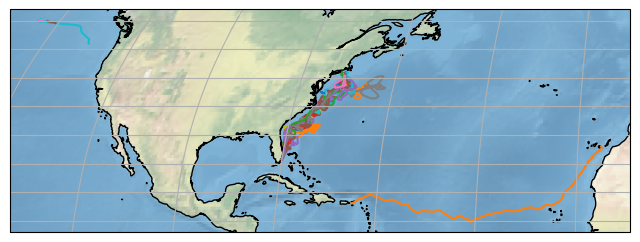

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
for ds_id in datasets_nrt:
    df_sub =df_all[df_all["dataset_id"]==ds_id]
    ax.plot(df_sub["longitude (degrees_east)"][::10],
            df_sub["latitude (degrees_north)"][::10],
           label=ds_id, transform=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
#ax.set_extent([-85, -58, 20, 45], crs=ccrs.PlateCarree())
ax.gridlines()
#ax.legend()
